In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Patch Features <a target="_blank" href="https://colab.research.google.com/github/facebookresearch/dinov2/blob/main/notebooks/patch_features.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import os
import sys

os.environ["XFORMERS_DISABLED"] = "1" # Switch to enable xFormers

INSTALL = False # Switch this to install dependencies
if INSTALL:
    !{sys.executable} -m pip install -U scikit-image scikit-learn ipywidgets

## Fetch and load resources

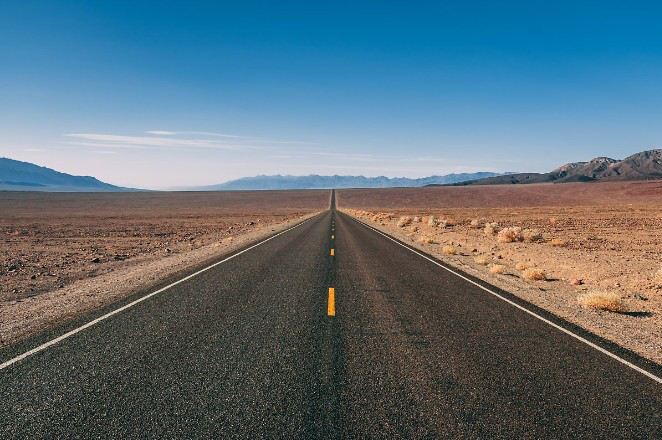

In [37]:
import urllib

import io
import numpy as np
from PIL import Image


def load_array_from_url(url: str) -> np.ndarray:
    with urllib.request.urlopen(url) as f:
        array_data = f.read()
        g = io.BytesIO(array_data)
        return np.load(g)


def load_image_from_file(file_path: str) -> Image:
    return Image.open(file_path).convert("RGB")


# Precomputed foreground / background projection
STANDARD_ARRAY_URL = "https://dl.fbaipublicfiles.com/dinov2/arrays/standard.npy"
standard_array = load_array_from_url(STANDARD_ARRAY_URL)

EXAMPLE_IMAGE_FILE = "/Users/byeon/Desktop/dinov2/road.jpg"
example_image = load_image_from_file(EXAMPLE_IMAGE_FILE)
display(example_image)

## Filter background, compute PCA and visualize projection

using dinov2_vitb14 model


Using cache found in /Users/byeon/.cache/torch/hub/facebookresearch_dinov2_main


patch size: 14


/var/folders/6c/13vntwtd5xb8dthjxcs5vhg80000gn/T/ipykernel_87249/1326149891.py:108: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  result_image = result_image.resize((image.width, image.height), Image.BICUBIC)


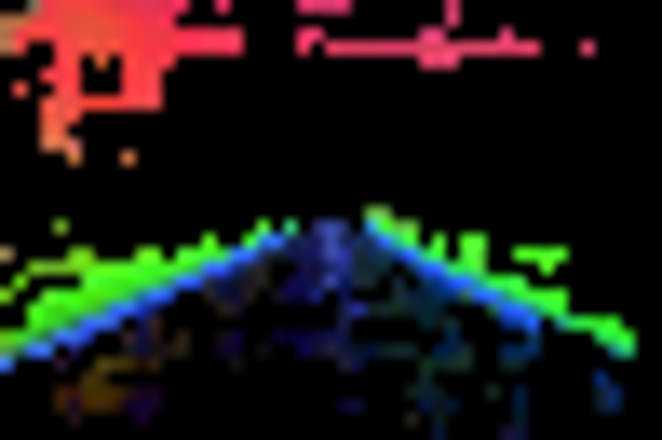

In [39]:
from typing import Tuple

import numpy as np
from PIL import Image
from sklearn.decomposition import PCA
from scipy.ndimage import binary_closing, binary_opening
import torch
import torchvision.transforms as transforms


REPO_NAME = "facebookresearch/dinov2"
MODEL_NAME = "dinov2_vitb14"


DEFAULT_SMALLER_EDGE_SIZE = 448
DEFAULT_BACKGROUND_THRESHOLD = 0.05
DEFAULT_APPLY_OPENING = False
DEFAULT_APPLY_CLOSING = False


def make_transform(smaller_edge_size: int) -> transforms.Compose:
    IMAGENET_DEFAULT_MEAN = (0.485, 0.456, 0.406)
    IMAGENET_DEFAULT_STD = (0.229, 0.224, 0.225)
    interpolation_mode = transforms.InterpolationMode.BICUBIC

    return transforms.Compose([
        transforms.Resize(size=smaller_edge_size, interpolation=interpolation_mode, antialias=True),
        transforms.ToTensor(),
        transforms.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD),
    ])


def prepare_image(image: Image,
                  smaller_edge_size: float,
                  patch_size: int) -> Tuple[torch.Tensor, Tuple[int, int]]:
    transform = make_transform(int(smaller_edge_size))
    image_tensor = transform(image)

    # Pad image to dimensions that are a multiple of the patch size
    height, width = image_tensor.shape[1:]  # C x H x W
    pad_height = (patch_size - height % patch_size) % patch_size
    pad_width = (patch_size - width % patch_size) % patch_size
    pad_left = pad_width // 2
    pad_right = pad_width - pad_left
    pad_top = pad_height // 2
    pad_bottom = pad_height - pad_top

    image_tensor = torch.nn.functional.pad(image_tensor, (pad_left, pad_right, pad_top, pad_bottom))

    grid_size = ((height + pad_height) // patch_size, (width + pad_width) // patch_size)  # h x w
    return image_tensor, grid_size


def make_foreground_mask(tokens,
                         grid_size: Tuple[int, int],
                         background_threshold: float = 0.0,
                         apply_opening: bool = True,
                         apply_closing: bool = True):
    # Initialize standard_array with appropriate values
    standard_array = np.ones(tokens.shape[1])  # Assuming tokens is a 2D array

    projection = tokens @ standard_array
    mask = projection > background_threshold
    mask = mask.reshape(*grid_size)
    if apply_opening:
        mask = binary_opening(mask)
    if apply_closing:
        mask = binary_closing(mask)
    return mask.flatten()


def render_patch_pca(image: Image,
                     smaller_edge_size: float = 448,
                     patch_size: int = 14,
                     background_threshold: float = 0.05,
                     apply_opening: bool = False,
                     apply_closing: bool = False) -> Image:
    image_tensor, grid_size = prepare_image(image, smaller_edge_size, patch_size)

    with torch.inference_mode():
        image_batch = image_tensor.unsqueeze(0)
        tokens = model.get_intermediate_layers(image_batch)[0].squeeze()

    mask = make_foreground_mask(tokens,
                                grid_size,
                                background_threshold,
                                apply_opening,
                                apply_closing)

    if mask.sum() < 2:
        # If there are not enough tokens to fit PCA, return the original image
        return image

    pca = PCA(n_components=min(3, mask.sum()))
    pca.fit(tokens[mask])
    projected_tokens = pca.transform(tokens)

    t = torch.tensor(projected_tokens)
    t_min = t.min(dim=0, keepdim=True).values
    t_max = t.max(dim=0, keepdim=True).values
    normalized_t = (t - t_min) / (t_max - t_min)

    array = (normalized_t * 255).byte().numpy()
    array[~mask] = 0
    array = array.reshape(*grid_size, 3)

    result_image = Image.fromarray(array)
    result_image = result_image.resize((image.width, image.height), Image.BICUBIC)
    return result_image



print(f"using {MODEL_NAME} model")
model = torch.hub.load(repo_or_dir=REPO_NAME, model=MODEL_NAME)
model.eval()
print(f"patch size: {model.patch_size}")

render_patch_pca(image=example_image,
                 smaller_edge_size=DEFAULT_SMALLER_EDGE_SIZE,
                 patch_size=model.patch_size,
                 background_threshold=DEFAULT_BACKGROUND_THRESHOLD,
                 apply_opening=DEFAULT_APPLY_OPENING,
                 apply_closing=DEFAULT_APPLY_CLOSING)

## Simple controls to explore the PCA of patch features

In [26]:
if INSTALL: # Try installing package
    !{sys.executable} -m pip install -U ipywidgets


import ipywidgets as widgets


def get_image(image_data: bytes) -> Image:
    with io.BytesIO(image_data) as f:
        return Image.open(f).convert("RGB")


def get_image_data(image: Image) -> bytes:
    with io.BytesIO() as f:
        image.save(f, format="PNG")
        return f.getvalue()


def make_blank_image(size: Tuple[int, int]) -> Image:
    return Image.new(mode="RGBA", size=size, color=(0, 0, 0, 0))


blank_result = make_blank_image(size=example_image.size)

DEFAULT_IMAGE_DATA = get_image_data(example_image)
DEFAULT_RESULT_DATA = get_image_data(blank_result)

image_widget = widgets.Image(
    value=DEFAULT_IMAGE_DATA,
    width=512,
    height=384,
)
upload_widget = widgets.FileUpload(
    accept="image/*",
    multiple=False,
)
smaller_edge_size_widget = widgets.IntSlider(
    value=DEFAULT_SMALLER_EDGE_SIZE,
    min=84,
    max=1344,
    step=1,
    description="Image size (smaller edge):",
    disabled=False,
    continuous_update=False,
    orientation="horizontal",
    readout=True,
    readout_format="d",
    style={"description_width": "initial"},
    layout=widgets.Layout(width="50%"),
)
background_threshold_widget = widgets.FloatSlider(
    value=DEFAULT_BACKGROUND_THRESHOLD,
    min=-1.0,
    max=1.0,
    step=0.01,
    description="Background threshold:",
    disabled=False,
    continuous_update=False,
    orientation="horizontal",
    readout=True,
    readout_format="0.02f",
    style={"description_width": "initial"},
    layout=widgets.Layout(width="50%"),
)
apply_opening_widget = widgets.Checkbox(
    value=DEFAULT_APPLY_OPENING,
    description="Apply opening operation",
    indent=False,
)
apply_closing_widget = widgets.Checkbox(
    value=DEFAULT_APPLY_CLOSING,
    description="Apply closing operation",
    indent=False,
)
clear_widget = widgets.Button(
    description="Clear",
    disabled=False,
    button_style="",
    tooltip="Click to reset inputs",
    icon="",
)
submit_widget = widgets.Button(
    description="Submit",
    disabled=False,
    button_style="success",
    tooltip="Click to run with specified inputs",
    icon="check",
)
result_widget = widgets.Image(
    value=DEFAULT_RESULT_DATA,
    width=512,
    height=384,
)

image_hbox = widgets.HBox([image_widget, result_widget])
button_hbox = widgets.HBox([upload_widget, clear_widget, submit_widget])
settings_vbox = widgets.VBox([
    smaller_edge_size_widget,
    background_threshold_widget,
    apply_opening_widget,
    apply_closing_widget,
])

box_widget = widgets.VBox(children=[
    image_hbox,
    settings_vbox,
    button_hbox,
])


def upload_callback(widget):
    print("Updating image")

    image_data = upload_widget.value[0]["content"]
    image_widget.value = image_data

    image = get_image(image_data)
    blank_image = make_blank_image(image.size)
    result_data = get_image_data(blank_image)
    result_widget.value = result_data


def clear_callback(widget):
    print("Resetting inputs")

    image_widget.value = DEFAULT_IMAGE_DATA
    smaller_edge_size_widget.value = DEFAULT_SMALLER_EDGE_SIZE
    background_threshold_widget.value = DEFAULT_BACKGROUND_THRESHOLD
    apply_opening_widget.value = DEFAULT_APPLY_OPENING
    apply_closing_widget.value = DEFAULT_APPLY_CLOSING
    result_widget.value = DEFAULT_RESULT_DATA


def submit_callback(widget):
    print("Rendering PCA")

    image = get_image(image_widget.value)
    print(image.size)
    result = render_patch_pca(image=image,
                              smaller_edge_size= smaller_edge_size_widget.value ,
                              patch_size=model.patch_size,
                              background_threshold=background_threshold_widget.value,
                              apply_opening=apply_opening_widget.value,
                              apply_closing=apply_closing_widget.value)
    result_data = get_image_data(result)
    result_widget.value = result_data


upload_widget.observe(upload_callback, names="value")
clear_widget.on_click(clear_callback)
submit_widget.on_click(submit_callback)

display(box_widget)